<a href="https://colab.research.google.com/github/Kartik-saxena/LANL-Eartquake-Prediction/blob/master/LANL_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!pip install numpy
!pip install -q kaggle

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [3]:
# Upload kagle.json, which is downloaded from 'my account' on kaggle homepage
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle (1).json


In [3]:
# get name of competition
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3040           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11288            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4766           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         38           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3194           False  
recognizing-faces-in-the-wild                      2019-08-01 23:59:00  Playground       Knowledge      

In [4]:
# Download dataset
!kaggle competitions download -c LANL-Earthquake-Prediction


sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls

'kaggle (1).json'	 seg_42648c.csv   seg_8456d3.csv   seg_c20c06.csv
 kaggle.json		 seg_4280d9.csv   seg_845a2a.csv   seg_c21723.csv
 sample_data		 seg_428d66.csv   seg_8472f3.csv   seg_c21d60.csv
 sample_submission.csv	 seg_42c4c9.csv   seg_848695.csv   seg_c22bd4.csv
 seg_00030f.csv		 seg_42e7e8.csv   seg_84a65d.csv   seg_c23429.csv
 seg_0012b5.csv		 seg_42ff14.csv   seg_84b9d9.csv   seg_c23641.csv
 seg_00184e.csv		 seg_430e66.csv   seg_84c7fb.csv   seg_c243a6.csv
 seg_003339.csv		 seg_43383f.csv   seg_84fc12.csv   seg_c24946.csv
 seg_0042cc.csv		 seg_434c96.csv   seg_8509db.csv   seg_c25855.csv
 seg_004314.csv		 seg_43597f.csv   seg_850d95.csv   seg_c267a5.csv
 seg_004cd2.csv		 seg_43c6f4.csv   seg_8515fd.csv   seg_c26fb4.csv
 seg_004ee5.csv		 seg_440106.csv   seg_853302.csv   seg_c27591.csv
 seg_004f1f.csv		 seg_4401d8.csv   seg_854d91.csv   seg_c2a0c8.csv
 seg_00648a.csv		 seg_441c6d.csv   seg_857304.csv   seg_c2b8f7.csv
 seg_006e4a.csv		 seg_4435bd.csv   seg_85762d.csv   seg_c3507

In [5]:
!unzip train.csv.zip


Archive:  train.csv.zip
  inflating: train.csv               


In [10]:
!unzip test.zip


Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_4a9e8d.csv          
  inflating: seg_32fc4e.csv          
  inflating: seg_7b2994.csv    

In [0]:
train_df = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows = 6000000)

In [17]:

test_check = pd.read_csv('seg_00030f.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(test_check.head())
print(test_check.shape)
del(test_check)

# Dimension of one test file is (150000,1)

   acoustic_data
0              4
1              0
2             -2
3              0
4              2
(150000, 1)


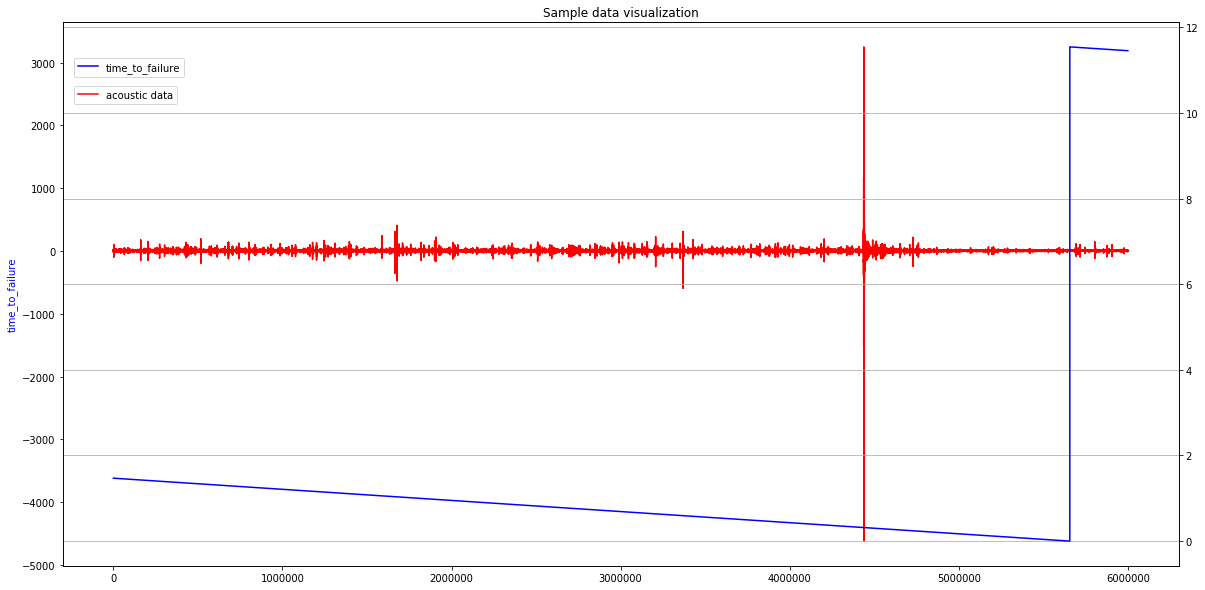

In [17]:
# Visual representation

fig,ax1 = plt.subplots(figsize = (20,10))
plt.title('Sample data visualization')
plt.plot(train_df['acoustic_data'], color = 'r')
ax1.set_ylabel('acoustic data', color = 'r')
plt.legend(['acoustic data'],loc=(0.01, 0.85))

ax2 = ax1.twinx()
plt.plot(train_df['time_to_failure'], color = 'b')
ax1.set_ylabel('time_to_failure', color = 'b')
plt.legend(['time_to_failure'],loc=(0.01, 0.9))
plt.grid(True)


In [0]:
def features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)


In [0]:
# Chunksize = 150000 because that is the exact size of test files

train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    t = features(df['acoustic_data'])
    X_train = X_train.append(t, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    
xtrain = StandardScaler().fit_transform(X_train)    

In [67]:
#  5 - Fold Random Forest Regressor 

kf = KFold(n_splits=5, random_state=None)
model = RandomForestRegressor(n_estimators=200,criterion='mse',oob_score=True, random_state=0)

for (train_index, test_index), i  in zip(kf.split(X_train,y_train),range(1,6)):
        
    model.fit(X_train.iloc[train_index],y_train.iloc[train_index])
    print("model",i," - ",model.score(X_train.iloc[test_index],y_train.iloc[test_index]))
    

model 1  -  0.4148729844913657
model 2  -  0.3176570528856453
model 3  -  0.24870630923414305
model 4  -  0.5355630297623764
model 5  -  0.26092080343805335


In [81]:
#  SVR Implementation with GridSearchCV

parameters = [{'gamma': [0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.5, 1, 1.5, 2]}]
               

model3 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
model3.fit(xtrain, y_train.ravel())

print("Best CV score: {:.4f}".format(model3.best_score_))
print(model3.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [124]:
#  Processing test data

seg_id = list()
X_test = pd.DataFrame()

for i in sorted(os.listdir(os.getcwd())):
  if i[0:3] == 'seg':
    temp = pd.read_csv(i, dtype={'acoustic_data': np.int16})
    t = features(temp['acoustic_data'])
    X_test = X_test.append(t,ignore_index = True)
    seg_id.append(i[0:-4])
 
xtest = StandardScaler().fit_transform(X_test)

del temp,X_test,t

(2624, 13)
         0         1      2      3   ...    9      10        11        12
0  4.491780  4.893690  -75.0  115.0  ...  18.0  115.0  5.224607  4.102161
1  4.171153  5.922839 -140.0  152.0  ...  20.0  152.0  5.198340  5.045369
2  4.610260  6.946990 -193.0  248.0  ...  20.0  248.0  5.597193  6.179525
3  4.531473  4.114147  -93.0   85.0  ...  14.0   93.0  4.961487  3.583863
4  4.128340  5.797164 -147.0  177.0  ...  19.0  177.0  5.070900  4.993617

[5 rows x 13 columns]


In [0]:
# Prediction and Output

y = model3.predict(xtest)
submission = pd.DataFrame({'seg_id':seg_id,'time_to_failure':list(y)})
submission.to_csv('submission.csv',index = False)
files.download('submission.csv')
